<a href="https://colab.research.google.com/github/BunnyNoBugs/minor2021-iad3-spring/blob/main/hw3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение

В этом задании Вы продолжите работать с данными из семинара [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).

In [2]:
import pandas as pd
import numpy as np
import math
import torch

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device='cpu'

## Загрузка и предобработка данных

Загрузим данные и проведем предобраотку данных как на семинаре.

In [4]:
!wget -q -N https://www.dropbox.com/s/z8syrl5trawxs0n/articles.zip?dl=0 -O articles.zip
!unzip -o -q articles.zip

In [5]:
articles_df = pd.read_csv('articles/shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(2)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en


In [6]:
interactions_df = pd.read_csv('articles/users_interactions.csv')
interactions_df.head(2)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US


In [7]:
interactions_df.personId = interactions_df.personId.astype(str)
interactions_df.contentId = interactions_df.contentId.astype(str)
articles_df.contentId = articles_df.contentId.astype(str)

In [8]:
# зададим словарь определяющий силу взаимодействия
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions_df['eventStrength'] = interactions_df.eventType.apply(lambda x: event_type_strength[x])

Оставляем только тех пользователей, которые произамодействовали более чем с пятью статьями.

In [9]:
users_interactions_count_df = (
    interactions_df
    .groupby(['personId', 'contentId'])
    .first()
    .reset_index()
    .groupby('personId').size())
print('# users:', len(users_interactions_count_df))

users_with_enough_interactions_df = \
    users_interactions_count_df[users_interactions_count_df >= 5].reset_index()[['personId']]
print('# users with at least 5 interactions:',len(users_with_enough_interactions_df))

# users: 1895
# users with at least 5 interactions: 1140


Оставляем только те взаимодействия, которые относятся к отфильтрованным пользователям.

In [10]:
interactions_from_selected_users_df = interactions_df.loc[np.in1d(interactions_df.personId,
            users_with_enough_interactions_df)]

In [11]:
print('# interactions before:', interactions_df.shape)
print('# interactions after:', interactions_from_selected_users_df.shape)

# interactions before: (72312, 9)
# interactions after: (69868, 9)


Объединяем все взаимодействия пользователя по каждой статье и сглаживаем полученный результат, взяв от него логарифм.

In [12]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId']).eventStrength.sum()
    .apply(smooth_user_preference)
    .reset_index().set_index(['personId', 'contentId'])
)
interactions_full_df['last_timestamp'] = (
    interactions_from_selected_users_df
    .groupby(['personId', 'contentId'])['timestamp'].last()
)
        
interactions_full_df = interactions_full_df.reset_index()
interactions_full_df.head(5)

,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.000000,1470395911
1,-1007001694607905623,-6623581327558800021,1.000000,1487240080
2,-1007001694607905623,-793729620925729327,1.000000,1472834892
3,-1007001694607905623,1469580151036142903,1.000000,1487240062
4,-1007001694607905623,7270966256391553686,1.584963,1485994324


Разобьём выборку на обучение и контроль по времени.

In [13]:
from sklearn.model_selection import train_test_split

split_ts = 1475519530
interactions_train_df = interactions_full_df.loc[interactions_full_df.last_timestamp < split_ts].copy()
interactions_test_df = interactions_full_df.loc[interactions_full_df.last_timestamp >= split_ts].copy()

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

interactions_train_df

# interactions on Train set: 29329
# interactions on Test set: 9777


,personId,contentId,eventStrength,last_timestamp
0,-1007001694607905623,-5065077552540450930,1.0,1470395911
2,-1007001694607905623,-793729620925729327,1.0,1472834892
6,-1032019229384696495,-1006791494035379303,1.0,1469129122
7,-1032019229384696495,-1039912738963181810,1.0,1459376415
8,-1032019229384696495,-1081723567492738167,2.0,1464054093
...,...,...,...,...
39099,997469202936578234,9112765177685685246,2.0,1472479493
39100,998688566268269815,-1255189867397298842,1.0,1474567164
39101,998688566268269815,-401664538366009049,1.0,1474567449
39103,998688566268269815,6881796783400625893,1.0,1474567675


Для удобства подсчёта качества запишем данные в формате, где строка соответствует пользователю, а столбцы будут истинными метками и предсказаниями в виде списков.

In [14]:
interactions = (
    interactions_train_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
    .reset_index()
    .rename(columns={'contentId': 'true_train'})
    .set_index('personId')
)

interactions['true_test'] = (
    interactions_test_df
    .groupby('personId')['contentId'].agg(lambda x: list(x))
)

# заполнение пропусков пустыми списками
interactions.loc[pd.isnull(interactions.true_test), 'true_test'] = [
    list() for x in range(len(interactions.loc[pd.isnull(interactions.true_test), 'true_test']))]

interactions.head(1)

,true_train,true_test
personId,,
-1007001694607905623,"[-5065077552540450930, -793729620925729327]","[-6623581327558800021, 1469580151036142903, 72..."


## Библиотека LightFM

Для рекомендации Вы будете пользоваться библиотекой [LightFM](https://making.lyst.com/lightfm/docs/home.html), в которой реализованы популярные алгоритмы. Для оценивания качества рекомендации, как и на семинаре, будем пользоваться метрикой *precision@10*.

In [15]:
!pip install lightfm
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

## Задание 1. (2 балла)

Модели в LightFM работают с разреженными матрицами. Создайте разреженные матрицы `data_train` и `data_test` (размером количество пользователей на количество статей), такие что на пересечении строки пользователя и столбца статьи стоит сила их взаимодействия, если взаимодействие было, и стоит ноль, если взаимодействия не было.

In [16]:
from scipy.sparse import lil_matrix, csr_matrix

In [17]:
users_id_to_idx = pd.DataFrame(interactions_full_df['personId'].unique(), columns=['id'])
users_id_to_idx = users_id_to_idx.reset_index()
users_id_to_idx = users_id_to_idx.set_index('id')

articles_id_to_idx = pd.DataFrame(interactions_full_df['contentId'].unique(), columns=['id'])
articles_id_to_idx = articles_id_to_idx.reset_index()
articles_id_to_idx = articles_id_to_idx.set_index('id')

In [18]:
# Ваш код здесь

n_users = len(interactions_full_df['personId'].unique())
n_articles = len(interactions_full_df['contentId'].unique())

data_train = lil_matrix((n_users, n_articles))
data_test = lil_matrix((n_users, n_articles))

In [19]:
for i in interactions_train_df.iterrows():
    user_idx = users_id_to_idx.loc[i[1]['personId']]['index']
    article_idx = articles_id_to_idx.loc[i[1]['contentId']]['index']
    interaction_strength = i[1]['eventStrength']

    data_train[user_idx, article_idx] = interaction_strength

for i in interactions_test_df.iterrows():
    user_idx = users_id_to_idx.loc[i[1]['personId']]['index']
    article_idx = articles_id_to_idx.loc[i[1]['contentId']]['index']
    interaction_strength = i[1]['eventStrength']

    data_test[user_idx, article_idx] = interaction_strength

In [20]:
data_train = data_train.tocsr()
data_test = data_test.tocsr()

## Задание 2. (1 балл)

Обучите модель LightFM с `loss='warp'` и посчитайте *precision@10* на тесте.

In [21]:
# Ваш код здесь
model = LightFM(no_components=30, loss='warp')
%time model.fit(data_train, epochs=4)
print(f'Train precision: {precision_at_k(model, data_train).mean()}')
print(f'Test precision: {precision_at_k(model, data_test).mean()}')

CPU times: user 229 ms, sys: 1.96 ms, total: 231 ms
Wall time: 232 ms
Train precision: 0.20890288054943085
Test precision: 0.003971486818045378


## Задание 3. (3 балла)

При вызове метода `fit` LightFM позволяет передавать в `item_features` признаковое описание объектов. Воспользуемся этим. Будем получать признаковое описание из текста статьи в виде [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF) (можно воспользоваться `TfidfVectorizer` из scikit-learn). Создайте матрицу `feat` размером количесвто статей на размер признакового описание и обучите LightFM с `loss='warp'` и посчитайте precision@10 на тесте.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
articles_content = articles_df.copy()
articles_content = articles_content.set_index('contentId')
articles_content['content'] = articles_content['title'] + ' ' + articles_content['text']
articles_content

,timestamp,eventType,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,content
contentId,,,,,,,,,,,,,
-4110354420726924665,1459193988,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,"Ethereum, a Virtual Currency, Enables Transact..."
-7292285110016212249,1459194146,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,Bitcoin Future: When GBPcoin of Branson Wins O...
-6151852268067518688,1459194474,CONTENT SHARED,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,Google Data Center 360° Tour We're excited to ...
2448026894306402386,1459194497,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,"IBM Wants to ""Evolve the Internet"" With Blockc..."
-2826566343807132236,1459194522,CONTENT SHARED,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,IEEE to Talk Blockchain at Cloud Computing Oxf...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9213260650272029784,1487946604,CONTENT SHARED,3609194402293569455,7144190892417579456,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt,"Conheça a Liga IoT, plataforma de inovação abe..."
-3295913657316686039,1487947067,CONTENT SHARED,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,Amazon takes on Skype and GoToMeeting with its...
3618271604906293310,1488223224,CONTENT SHARED,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,"Code.org 2016 Annual Report February 9, 2017 -..."


In [24]:
articles_id_to_idx = articles_id_to_idx.join(articles_content['content'])
articles_id_to_idx

,index,content
id,,
-5065077552540450930,0,Ranking das maiores seguradoras da Europa - 20...
-6623581327558800021,1,"Spanner, the Google Database That Mastered Tim..."
-793729620925729327,2,Closure Compiler in JavaScript Posted by Sam T...
1469580151036142903,3,Don't document your code. Code your documentat...
7270966256391553686,4,Announcing .NET Core 1.0 We are excited to ann...
...,...,...
4106497696154898573,2979,Learn Swift Programming Syntax | Udacity Lesso...
-8464215556093549753,2980,HackerRank Women's CodeSprint 2016 Join Women'...
-8202212195240926680,2981,Cover-More to raise $73.3 million to buy Trave...


In [25]:
articles_id_to_idx = articles_id_to_idx.fillna('')

In [26]:
vect = TfidfVectorizer()
feat = vect.fit_transform(articles_id_to_idx['content'])

In [27]:
%%time

model = LightFM(no_components=30, loss='warp')
model.fit(data_train, item_features=feat, epochs=20)
print(f'Train precision: {precision_at_k(model, data_train, item_features=feat).mean()}')
print(f'Test precision: {precision_at_k(model, data_test, item_features=feat).mean()}')

Train precision: 0.36375898122787476
Test precision: 0.004276985768228769
CPU times: user 4min 13s, sys: 224 ms, total: 4min 13s
Wall time: 4min 12s


## Задание 4. (2 балла)

В задании 3 мы использовали сырой текст статей. В этом задании необходимо сначала сделать предобработку текста (привести к нижнему регистру, убрать стоп слова, привести слова к номральной форме и т.д.), после чего обучите модель и оценить качество на тестовых данных.

In [28]:
!pip install langdetect
from langdetect import detect

!python -m spacy download pt_core_news_sm
import en_core_web_sm, pt_core_news_sm
nlp_en = en_core_web_sm.load()
nlp_pt = pt_core_news_sm.load()

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [29]:
def preprocess_text(text):
    if text:
        lang = detect(text)
        if lang == 'pt':
            doc = nlp_pt(text)
        else:
            doc = nlp_en(text)
        text = ' '.join([token.lemma_.lower() for token in doc if token.lemma_.isalpha()])

    return text

In [30]:
%%time

articles_id_to_idx['content_preproc'] = articles_id_to_idx['content'].apply(preprocess_text) 

CPU times: user 12min 1s, sys: 40.7 s, total: 12min 41s
Wall time: 12min 40s


In [31]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
stopwords_en_pt = stopwords.words('english') + stopwords.words('portuguese')

In [33]:
vect = TfidfVectorizer(stop_words=stopwords_en_pt,
                    #    min_df=0.001
                       )

In [34]:
feat = vect.fit_transform(articles_id_to_idx['content_preproc'])

In [35]:
feat

<2984x51141 sparse matrix of type '<class 'numpy.float64'>'
	with 763777 stored elements in Compressed Sparse Row format>

In [36]:
# Ваш код здесь
%%time

model = LightFM(no_components=30, loss='warp')
model.fit(data_train, item_features=feat, epochs=20)
print(f'Train precision: {precision_at_k(model, data_train, item_features=feat).mean()}')
print(f'Test precision: {precision_at_k(model, data_test, item_features=feat).mean()}')

Train precision: 0.3599820137023926
Test precision: 0.0031568226404488087
CPU times: user 3min 1s, sys: 147 ms, total: 3min 1s
Wall time: 3min 1s


Улучшилось ли качество предсказания?

## Задание 5. (2 балла)

Подберите гиперпараметры модели LightFM (`n_components` и др.) для улучшения качества модели.

In [37]:
# Ваш код здесь
%%time

model = LightFM(no_components=30, loss='warp', learning_schedule='adagrad')
model.fit(data_train, item_features=feat, epochs=20)
print(f'Train precision: {precision_at_k(model, data_train, item_features=feat).mean()}')
print(f'Test precision: {precision_at_k(model, data_test, item_features=feat).mean()}')

Train precision: 0.36312949657440186
Test precision: 0.005091649480164051
CPU times: user 3min, sys: 150 ms, total: 3min
Wall time: 2min 59s


## Бонусное задание. (3 балла)

Выше мы использовали достаточно простое представление текста статьи в виде TF-IDF. В этом задании Вам нужно представить текст статьи (можно вместе с заголовком) в виде эмбеддинга полученного с помощью рекуррентной сети или трансформера (можно использовать любую предобученную модель, которая Вам нравится). Обучите модель с ипользованием этих эмеддингов и сравните результаты с предыдущими.

In [ ]:
!pip install transformers
from transformers import AutoTokenizer, AutoModel

     |████████████████████████████████| 2.1MB 18.4MB/s 
     |████████████████████████████████| 3.3MB 55.3MB/s 
     |████████████████████████████████| 901kB 53.8MB/s 


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModel.from_pretrained('bert-base-multilingual-cased')
model.to(device);

In [ ]:
def get_bert_embedding(text, tokenizer, model):
    inputs = tokenizer(text, truncation=True, return_tensors='pt')
    inputs.to(device)
    outputs = model(**inputs)

    return outputs[1].squeeze().detach().cpu().numpy()

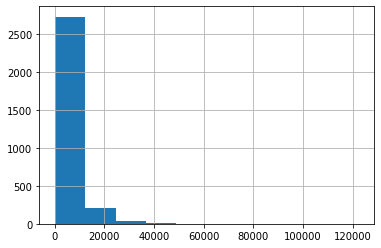

In [ ]:
articles_id_to_idx['content'].apply(len).hist()

In [ ]:
articles_id_to_idx

,index,content
id,,
-5065077552540450930,0,Ranking das maiores seguradoras da Europa - 20...
-6623581327558800021,1,"Spanner, the Google Database That Mastered Tim..."
-793729620925729327,2,Closure Compiler in JavaScript Posted by Sam T...
1469580151036142903,3,Don't document your code. Code your documentat...
7270966256391553686,4,Announcing .NET Core 1.0 We are excited to ann...
...,...,...
4106497696154898573,2979,Learn Swift Programming Syntax | Udacity Lesso...
-8464215556093549753,2980,HackerRank Women's CodeSprint 2016 Join Women'...
-8202212195240926680,2981,Cover-More to raise $73.3 million to buy Trave...


In [ ]:
%%time

articles_id_to_idx['bert_embedding'] = articles_id_to_idx['content'].apply(lambda x: get_bert_embedding(x, tokenizer, model))

CPU times: user 1min 14s, sys: 34.9 s, total: 1min 49s
Wall time: 1min 49s


In [ ]:
feat = csr_matrix(articles_id_to_idx['bert_embedding'].tolist())

In [ ]:
feat

<2984x768 sparse matrix of type '<class 'numpy.float32'>'
	with 2291712 stored elements in Compressed Sparse Row format>

In [ ]:
%%time

model = LightFM(no_components=50, loss='warp')
model.fit(data_train, item_features=feat, epochs=100)
print(f'Train precision: {precision_at_k(model, data_train, item_features=feat).mean()}')
print(f'Test precision: {precision_at_k(model, data_test, item_features=feat).mean()}')

Train precision: 0.14208632707595825
Test precision: 0.004989816341549158
CPU times: user 30min 21s, sys: 881 ms, total: 30min 22s
Wall time: 30min 16s
